In [1]:
using Distributed, Plots, GaussQuadrature, SparseArrays, DataFrames, LinearAlgebra, Random, BenchmarkTools, CUDA, StatsBase, DelimitedFiles

#CUDA.allowscalar()
CUDA.allowscalar(true)

@everywhere using CUDA

┌ Warning: It's not recommended to use allowscalar([true]) to allow scalar indexing.
│ Instead, use `allowscalar() do end` or `@allowscalar` to denote exactly which operations can use scalar operations.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/GMsgk/src/GPUArraysCore.jl:188


In [2]:
using Revise

In [3]:
function exemplo1()
	α = 1.0
	β = 1.0
	f(x₁,x₂) = (2*α*π^2+β) * sin(π*x₁) * sin(π*x₂)
	u(x₁,x₂) = sin(π*x₁) * sin(π*x₂)

	return α, β, f, u
end

exemplo1 (generic function with 1 method)

# Função $\varphi$

In [4]:
function ϕ(ξ₁,ξ₂,a)
	if a == 1
		return (1-ξ₁)*(1-ξ₂)/4
	elseif a == 2
		return (1+ξ₁)*(1-ξ₂)/4
	elseif a == 3
		return (1+ξ₁)*(1+ξ₂)/4
	elseif a == 4
		return (1-ξ₁)*(1+ξ₂)/4
	else
		error("a deve ser 1, 2, 3 ou 4.")
	end
end


function ϕ(ξ₁::Float64, ξ₂::Float64) :: Vector{Float64}
	[(1-ξ₁)*(1-ξ₂)/4, (1+ξ₁)*(1-ξ₂)/4, (1+ξ₁)*(1+ξ₂)/4, (1-ξ₁)*(1+ξ₂)/4]
end

ϕ (generic function with 2 methods)

# Derivadas de $\varphi$

In [5]:
@inline function ∂ϕ_∂ξ₁(ξ₁::Float64,ξ₂::Float64,a::Int)
	val = ifelse(a == 1, -(1-ξ₂)/4,
           ifelse(a == 2, (1-ξ₂)/4,
           ifelse(a == 3, (1+ξ₂)/4,
           ifelse(a == 4, -(1+ξ₂)/4, NaN))))
    return val
end

@inline function ∂ϕ_∂ξ₁(ξ₂::Float64) :: Vector{Float64}
	[-(1-ξ₂)/4, (1-ξ₂)/4, (1+ξ₂)/4, -(1+ξ₂)/4]
end

∂ϕ_∂ξ₁ (generic function with 2 methods)

In [6]:
@inline function ∂ϕ_∂ξ₂(ξ₁::Float64, ξ₂::Float64, a::Int)
    # Replace `if-elseif` with a `switch`-like computation for CUDA
    val = ifelse(a == 1, -(1-ξ₁)/4,
           ifelse(a == 2, -(1+ξ₁)/4,
           ifelse(a == 3, (1+ξ₁)/4,
           ifelse(a == 4, (1-ξ₁)/4, NaN))))
    return val
end

@inline function ∂ϕ_∂ξ₂(ξ₁::Float64) :: Vector{Float64}
	[-(1-ξ₁)/4, -(1+ξ₁)/4, (1+ξ₁)/4, (1-ξ₁)/4]
end

∂ϕ_∂ξ₂ (generic function with 2 methods)

In [7]:
function precompute_∂ϕ_∂ξ₁(P::Vector{Float64})::Vector{Float64}
    n = length(P)
    phi_flat = Vector{Float64}(undef, 4 * n^2)
    for a in 1:4
        for i in 1:n
            ξ₁ = P[i]
            for j in 1:n
                ξ₂ = P[j]
                index = (a - 1) * n^2 + (i - 1) * n + (j - 1) + 1
                if a == 1
                    phi_flat[index] = -(1-ξ₂)/4
                elseif a == 2
                    phi_flat[index] = (1-ξ₂)/4
                elseif a == 3
                    phi_flat[index] = (1+ξ₂)/4
                elseif a == 4
                    phi_flat[index] = -(1+ξ₂)/4
                end
            end
        end
    end
    return phi_flat
end

function precompute_∂ϕ_∂ξ₂(P::Vector{Float64})::Vector{Float64}
    n = length(P)
    phi_flat = Vector{Float64}(undef, 4 * n^2)
    for a in 1:4
        for i in 1:n
            ξ₁ = P[i]
            for j in 1:n
                ξ₂ = P[j]
                index = (a - 1) * n^2 + (i - 1) * n + (j - 1) + 1
                if a == 1
                    phi_flat[index] = -(1-ξ₁)/4
                elseif a == 2
                    phi_flat[index] = -(1+ξ₁)/4
                elseif a == 3
                    phi_flat[index] = (1+ξ₁)/4
                elseif a == 4
                    phi_flat[index] = (1-ξ₁)/4
                end
            end
        end
    end
    return phi_flat
end

precompute_∂ϕ_∂ξ₂ (generic function with 1 method)

# Mudança de variável

In [8]:
@inline function x₁_de_ξ(ξ₁::Float64, h₁::Float64, p₁::Float64)::Float64
    return p₁ + (h₁ / 2) * (ξ₁ + 1)
end

@inline function x₂_de_ξ(ξ₂::Float64, h₂::Float64, p₂::Float64)::Float64
    return p₂ + (h₂ / 2) * (ξ₂ + 1)
end

x₂_de_ξ (generic function with 1 method)

# Montagem da F local

In [9]:
function monta_Fᵉ!(Fᵉ::Vector{Float64}, f::Function, h₁::Float64, h₂::Float64, p₁::Float64, p₂::Float64, P::Vector{Float64}, W::Vector{Float64})
    # Zera as entradas do vetor local Fᵉ
    fill!(Fᵉ, 0.0)

    # Pré-calcula o fator constante da integral
    cst = h₁ * h₂ / 4

    phi_values = precompute_ϕ_flat(P)

    # Loop sobre as entradas do vetor local Fᵉ
    for a in 1:4
        # Inicializa a contribuição da quadratura para a entrada a
        soma = 0.0
    
        # Integração via quadratura gaussiana dupla
        length_P = length(P)
        for i in 1:length_P          # Loop sobre os pontos de quadratura no eixo ξ₁
            ξ₁ = P[i]
            x₁ = x₁_de_ξ(ξ₁, h₁, p₁)
            for j in 1:length_P      # Loop sobre os pontos de quadratura no eixo ξ₂
                ξ₂ = P[j]
                x₂ = x₂_de_ξ(ξ₂, h₂, p₂)

                # Acumula a contribuição da quadratura
                #soma += W[i] * W[j] * f(x₁, x₂) * ϕ(ξ₁, ξ₂, a) * cst
                index = (a - 1) * length_P^2 + (i - 1) * length_P + (j - 1) + 1
                soma += W[i] * W[j] * f(x₁, x₂) * phi_values[index] * cst
            end
        end
    
        # Armazena a contribuição no vetor Fᵉ
        Fᵉ[a] = soma
    end
end

function precompute_ϕ_flat(P::Vector{Float64})::Vector{Float64}
    n = length(P)
    phi_flat = Vector{Float64}(undef, 4 * n^2)

    for a in 1:4
        for i in 1:n
            ξ₁ = P[i]
            for j in 1:n
                ξ₂ = P[j]
                index = (a - 1) * n^2 + (i - 1) * n + (j - 1) + 1
                if a == 1
                    phi_flat[index] = (1 - ξ₁) * (1 - ξ₂) / 4
                elseif a == 2
                    phi_flat[index] = (1 + ξ₁) * (1 - ξ₂) / 4
                elseif a == 3
                    phi_flat[index] = (1 + ξ₁) * (1 + ξ₂) / 4
                elseif a == 4
                    phi_flat[index] = (1 - ξ₁) * (1 + ξ₂) / 4
                end
            end
        end
    end
    return phi_flat
end

function monta_Fᵉ_cuda_correct!(Fᵉ, f::Function, h₁::Float64, h₂::Float64, p₁::Float64, p₂::Float64, P, W, phi_values)
    # Zera as entradas do vetor local Fᵉ
    CUDA.fill!(Fᵉ, 0.0)

	cst = h₁ * h₂ / 4

    # GPU kernel definition
    kernel_monta_Fᵉ = nothing
    function kernel_monta_Fᵉ!(
        Fᵉ, f::Function, h₁::Float64, h₂::Float64, p₁::Float64, p₂::Float64, P::CuDeviceVector{Float64, 1}, W::CuDeviceVector{Float64, 1}, cst::Float64
    )
        a = threadIdx().x
        soma = 0.0
        length_P = length(P)
        for i in 1:length_P     # Loop over quadrature points in ξ₁
            ξ₁ = P[i]
            x₁ = x₁_de_ξ(ξ₁, h₁, p₁)
            for j in 1:length_P # Loop over quadrature points in ξ₂
                ξ₂ = P[j]
                x₂ = x₂_de_ξ(ξ₂, h₂, p₂)
                # Accumulate the quadrature contribution
                index = (a - 1) * length_P^2 + (i - 1) * length_P + (j - 1) + 1
                soma += W[i] * W[j] * f(x₁, x₂) * phi_values[index] * cst
            end
        end
        # Store the result in Fᵉ
        Fᵉ[a] = soma
        return nothing
    end

    # Launch the kernel with 4 threads (one for each `a`)
    @cuda threads=4 kernel_monta_Fᵉ!(Fᵉ, f, h₁, h₂, p₁, p₂, P, W, cst)
end

monta_Fᵉ_cuda_correct! (generic function with 1 method)

In [10]:
function teste_monta_Fᵉ_cuda_correct()
	Fᵉ = CUDA.zeros(4)
	
	P1, W1 = legendre(5)
	phi_values = CuArray(precompute_ϕ_flat(P1))
    P, W = CuArray(P1), CuArray(W1)
	
	h₁ = 1/4
	h₂ = 1/4
	
	p₁ = 0.0
	p₂ = 0.0
	
	@inline function f(x₁,x₂) 
		return 4/(h₁*h₂)
	end

	monta_Fᵉ_cuda_correct!(Fᵉ, f, h₁, h₂, p₁, p₂, P, W, phi_values)
    display("Fᵉ - Teste 1")
	display(Fᵉ)
	
	monta_Fᵉ_cuda_correct!(Fᵉ, (x₁,x₂) -> (16*9*x₁*x₂)/((h₁*h₂)^2), h₁, h₂, p₁, p₂, P, W, phi_values)
    display("Fᵉ - Teste 2")
	display(Fᵉ)
end

teste_monta_Fᵉ_cuda_correct (generic function with 1 method)

In [ ]:
teste_monta_Fᵉ_cuda_correct()

# Montagem da K local

In [ ]:
function monta_Kᵉ(α::Float64, β::Float64, h₁::Float64, h₂::Float64, P::Vector{Float64}, W::Vector{Float64}) ::Matrix{Float64}
    # Inicializa a matriz local Kᵉ
    Kᵉ = zeros(4, 4)

    # Pré-calcula os fatores constantes das integrais
    cst1 = α * (h₂ / h₁)
    cst2 = α * (h₁ / h₂)
    cst3 = β * (h₁ * h₂ / 4)

    # Loop sobre as colunas (b) e linhas (a) da matriz local Kᵉ
    for b in 1:4
        for a in 1:4
            # Inicializa a contribuição da quadratura para a entrada (a, b)
            soma = 0.0

            # Integração via quadratura gaussiana dupla
            for i in 1:length(P)     # Loop sobre os pontos de quadratura no eixo ξ₁
				ξ₁ = P[i]
                for j in 1:length(P) # Loop sobre os pontos de quadratura no eixo ξ₂
                    ξ₂ = P[j]

                    # Acumula a contribuição da quadratura
                    soma += W[i] * W[j] * (
                        cst1 * ∂ϕ_∂ξ₁(ξ₁, ξ₂, b) * ∂ϕ_∂ξ₁(ξ₁, ξ₂, a) + 
                        cst2 * ∂ϕ_∂ξ₂(ξ₁, ξ₂, b) * ∂ϕ_∂ξ₂(ξ₁, ξ₂, a) + 
                        cst3 *      ϕ(ξ₁, ξ₂, b) *      ϕ(ξ₁, ξ₂, a)    
                    )
                end
            end

            # Armazena a contribuição acumulada na entrada [a, b] da matriz Kᵉ
            Kᵉ[a, b] = soma
        end
    end

    return Kᵉ
end

In [ ]:
function teste_monta_Kᵉ()
	h₁ = 1/4
	h₂ = 1/4

	P, W = legendre(2)

	# Teste 1
	α = 6.0
	β = 0.0
	Kᵉ = monta_Kᵉ(α, β, h₁, h₂, P, W)
	display("Kᵉ - Teste 1")
	display(Kᵉ)

	# Teste 2
	α = 0.0
	β = (9*4)/(h₁*h₂)
	Kᵉ = monta_Kᵉ(α, β, h₁, h₂, P, W)
	display("Kᵉ - Teste 2")
	display(Kᵉ)	
end

# Montagem de LG e EQ

In [ ]:
function monta_LG(Nx1::Int64, Nx2::Int64)::Matrix{Int64}
    # Define o número de funções φ no eixo x₁ e x₂
    nx1 = Nx1 + 1
    nx2 = Nx2 + 1

    # M[:,j] contém a numeração da primeira linha do "Bloco j"
    M = (1:nx1-1) .+ (0:nx1:(nx2-2)*nx1)'

    # LG[1,:] contém a numeração global da primeira função local de cada elemento 
    linha1 = reshape(M, 1, :)

    # Constrói a matriz LG
    LG = vcat(linha1, linha1 .+ 1, linha1 .+ (nx1+1), linha1 .+ nx1)

    return LG
end

In [ ]:
function monta_EQ(Nx1::Int64, Nx2::Int64) :: Tuple{Int64,Vector{Int64}}
    # Define o número de funções φ no eixo x₁ e x₂
    nx1 = Nx1 + 1
    nx2 = Nx2 + 1
    
    # Calcula o número de funções globais φ que compõem a base do espaço Vₘ
    m = (nx1-2) * (nx2-2)

    # Inicializa o vetor EQ preenchido com m+1
    EQ = fill(m+1, nx1 * nx2)

    # Vetor contendo os índices das funções globais φ que compõem a base do espaço Vₘ
    L = reshape( (0:nx1-3) .+ (nx1+2:nx1:(nx2-2)*nx1+2)' , :,1)

    # Atribui os valores de 1 até m as funções globais φ que compõem a base do espaço Vₘ
    EQ[L] = 1:m

    return m, EQ
end

# Montagem da F global

In [ ]:
function monta_F(f::Function, Nx1::Int64, Nx2::Int64, m::Int64, EQoLG::Matrix{Int64})
    # Comprimento da base (h₁) e altura (h₂) de cada elemento retangular Ωᵉ
    h₁ = 1 / Nx1
    h₂ = 1 / Nx2

    # Número total de elementos finitos na malha
    ne = Nx1 * Nx2

    # P: Pontos de quadratura de Gauss-Legendre (ordem 5)
    # W: Pesos de quadratura de Gauss-Legendre
    P, W = legendre(5)

    # Inicializa o vetor local Fᵉ
    Fᵉ = zeros(4)

    # Inicializa o vetor global F com tamanho (m+1)
    F = zeros(m+1)
    
    # Loop sobre os elementos Ωᵉ (percorrendo cada subdivisão ao longo de x₂ e x₁)
    for j = 1:Nx2
        # Segunda componente do ponto inferior esquerdo do retângulo `Ωᵉ`.
        p₂ = (j-1)*h₂ 
        for i = 1:Nx1
            # Primeira componente do ponto inferior esquerdo do retângulo `Ωᵉ`.
            p₁ = (i-1)*h₁
            # Numeração do elemento finito atual (e) na malha
            e = (j-1)*Nx1 + i 

            # Calcula o vetor local Fᵉ para o elemento e
            monta_Fᵉ!(Fᵉ, f, h₁, h₂, p₁, p₂, P, W) 

            # Acumula Fᵉ em F usando a matriz de conectividade EQoLG
            for a = 1:4
                F[EQoLG[a,e]] += Fᵉ[a]
            end
        end
    end

    # Retorna o vetor global F com tamanho `m`, excluindo a última entrada adicional
    return F[1:m]
end

function monta_F_cuda(f::Function, Nx1::Int64, Nx2::Int64, m::Int64, EQoLG)
    # Comprimento da base (h₁) e altura (h₂) de cada elemento retangular Ωᵉ
    h₁ = 1 / Nx1
    h₂ = 1 / Nx2

    # Número total de elementos finitos na malha
    ne = Nx1 * Nx2

    # P: Pontos de quadratura de Gauss-Legendre (ordem 5)
    # W: Pesos de quadratura de Gauss-Legendre
    P, W = legendre(5)
    #P, W = CuArray(P), CuArray(W)

    # Inicializa o vetor local Fᵉ
    Fᵉ = CUDA.zeros(4)

    # Inicializa o vetor global F com tamanho (m+1)
    F = CUDA.zeros(m+1)
    
    # Loop sobre os elementos Ωᵉ (percorrendo cada subdivisão ao longo de x₂ e x₁)
    for j = 1:Nx2
        # Segunda componente do ponto inferior esquerdo do retângulo `Ωᵉ`.
        p₂ = (j-1)*h₂ 
        for i = 1:Nx1
            # Primeira componente do ponto inferior esquerdo do retângulo `Ωᵉ`.
            p₁ = (i-1)*h₁
            # Numeração do elemento finito atual (e) na malha
            e = (j-1)*Nx1 + i 

            # Calcula o vetor local Fᵉ para o elemento e
            monta_Fᵉ_cuda!(Fᵉ, f, h₁, h₂, p₁, p₂, P, W)

            # Acumula Fᵉ em F usando a matriz de conectividade EQoLG
            for a = 1:4
                F[EQoLG[a,e]] += Fᵉ[a]
            end
        end
    end

    # Retorna o vetor global F com tamanho `m`, excluindo a última entrada adicional
    return F[1:m]
end

In [ ]:
function teste_monta_F()
	# Teste 1
	#Nx1 = 4; Nx2 = 3; h₁ = 1/Nx1; h₂ = 1/Nx2;
	
	#m, EQ = monta_EQ(Nx1,Nx2)
	#LG = monta_LG(Nx1,Nx2)
	#EQoLG = EQ[LG]
	
	#F = monta_F((x₁,x₂) -> 4.0/(h₁*h₂), Nx1, Nx2, m, EQoLG)
    #display("F - Teste 1")
	#display("Nx1 = 4; Nx2 = 3; h₁ = 1/Nx1; h₂ = 1/Nx2; f(x₁,x₂) = 4/(h₁*h₂);")
	#display(F)
	
	# Teste 2
	Nx1 = 4; Nx2 = 4; h₁ = 1/Nx1; h₂ = 1/Nx2;
	
	m, EQ = monta_EQ(Nx1,Nx2)
	LG = monta_LG(Nx1,Nx2)
	EQoLG = EQ[LG]
	
	F = monta_F((x₁,x₂) -> (16*9*x₁*x₂)/((h₁*h₂)^2), Nx1, Nx2, m, EQoLG)
    display("F - Teste 2")
	display("Nx1 = Nx2 = 4; h₁ = 1/Nx1; h₂ = 1/Nx2; f(x₁,x₂) = (16*9*x₁*x₂)/((h₁*h₂)^2);")
	display(F)
end

In [ ]:
teste_monta_F()

In [ ]:
function teste_monta_F_cuda()
	# #Teste 1
	# Nx1 = 4; Nx2 = 3; h₁ = 1/Nx1; h₂ = 1/Nx2;
	
	# m, EQ = monta_EQ(Nx1,Nx2)
	# LG = monta_LG(Nx1,Nx2)
	# EQoLG = EQ[LG]
	
	# F = monta_F_cuda((x₁,x₂) -> 4.0/(h₁*h₂), Nx1, Nx2, m, EQoLG)
    # display("F - Teste 1")
	# display("Nx1 = 4; Nx2 = 3; h₁ = 1/Nx1; h₂ = 1/Nx2; f(x₁,x₂) = 4/(h₁*h₂);")
	# display(F)
	
	# Teste 2
	Nx1 = 4; Nx2 = 4; h₁ = 1/Nx1; h₂ = 1/Nx2;
	
	m, EQ = monta_EQ(Nx1,Nx2)
	LG = monta_LG(Nx1,Nx2)
	EQoLG = EQ[LG]
	
	F = monta_F_cuda((x₁,x₂) -> (16*9*x₁*x₂)/((h₁*h₂)^2), Nx1, Nx2, m, EQoLG)
    display("F - Teste 2")
	display("Nx1 = Nx2 = 4; h₁ = 1/Nx1; h₂ = 1/Nx2; f(x₁,x₂) = (16*9*x₁*x₂)/((h₁*h₂)^2);")
	display(F)
end

In [ ]:
teste_monta_F_cuda()

# Montagem da K global

In [ ]:
function monta_K(α::Float64, β::Float64, Nx1::Int64, Nx2::Int64, m::Int64, EQoLG::Matrix{Int64}) :: SparseMatrixCSC{Float64, Int64}
    h₁ = 1 / Nx1 # Comprimento da base do elemento finito retangular Ωᵉ
    h₂ = 1 / Nx2 # Comprimento da altura do elemento finito retangular Ωᵉ

    # Número de elementos na malha
    ne = Nx1 * Nx2

    # Pontos e pesos de quadratura de Gauss-Legendre
    P, W = legendre(2)

    # Calcula a matriz local Kᵉ
    Kᵉ = monta_Kᵉ(α, β, h₁, h₂, P, W)

    # Inicializa a matriz esparsa K com tamanho (m+1) x (m+1)
    K = spzeros(m+1, m+1)

    # Loop sobre os elementos
    for e = 1:ne
        # Loop sobre as colunas (b) e linhas (a) da matriz local Kᵉ
        for b = 1:4
            j = EQoLG[b,e]
            for a = 1:4
                i = EQoLG[a,e]
                K[i,j] += Kᵉ[a,b]
            end
        end
    end
   
    # Remove a última linha e coluna da matriz K
    return K[1:m, 1:m]
end

function kernel_assemble_K!(
        K_vals::CuDeviceVector{Float64, 1},
        K_rows::CuDeviceVector{Int64, 1}, 
        K_cols::CuDeviceVector{Int64, 1},
        EQoLG::CuDeviceMatrix{Int64,1},
        K_e::CuDeviceMatrix{Float64,1},
        ne::Int64)
    idx = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    total_entries = ne * 16  # 4x4 contributions per element

    if idx <= total_entries
        # element index
        e = div(idx-1, 16) + 1
        ab = rem(idx-1, 16)
        a = div(ab, 4) + 1
        b = rem(ab, 4) + 1

        i = EQoLG[a, e]
        j = EQoLG[b, e]
        val = K_e[a, b]

        # you only need to store the global values togheter with its indices, doesn't matter the order
        K_rows[idx] = i
        K_cols[idx] = j
        K_vals[idx] = val
    end
    return nothing
end

### coo2csc

In [ ]:
function coo2csc(K_rows, K_cols, K_vals, m)
    # Step 0: Sum repeated indices
    combined_dict = Dict{Tuple{Int, Int}, Float64}()
    for i in 1:length(K_rows)
        key = (K_rows[i], K_cols[i])
        if haskey(combined_dict, key)
            combined_dict[key] += K_vals[i]  # Sum the values
        else
            combined_dict[key] = K_vals[i]
        end
    end

    unique_rows = Int[]
    unique_cols = Int[]
    unique_vals = Float64[]
    
    for ((r, c), v) in combined_dict
        push!(unique_rows, r)
        push!(unique_cols, c)
        push!(unique_vals, v)
    end

    # Step 1: Sort everything
    sorted_indices = sortperm(unique_rows, by = identity)
    K_rows = unique_rows[sorted_indices]
    K_cols = unique_cols[sorted_indices]
    K_vals = unique_vals[sorted_indices]
    sorted_indices = sortperm(K_cols, by = identity)
    K_rows = K_rows[sorted_indices]
    K_cols = K_cols[sorted_indices]
    K_vals = K_vals[sorted_indices]

    # Step 2: Initialize col_pointers
    col_pointers = zeros(Int, m + 2)

    # Step 3: Count occurrences of each column index
    for col in K_cols
        col_pointers[col + 1] += 1
    end

    # Step 4: Perform cumulative sum
    for i in 2:length(col_pointers)
        col_pointers[i] += col_pointers[i - 1]
    end

    # Step 5: Change from zero-based to one-based
    col_pointers .+= 1
    return col_pointers, K_rows, K_vals
end

### monta_k_cuda

In [ ]:
function monta_K_cuda(α::Float64, β::Float64, Nx1::Int64, Nx2::Int64, m::Int64, EQoLG0::Matrix{Int64})::CUDA.CUSPARSE.CuSparseMatrixCOO
    h₁ = 1 / Nx1  # Width of the finite element base
    h₂ = 1 / Nx2  # Height of the finite element

    # Number of elements in the mesh
    ne = Nx1 * Nx2

    EQoLG = CuMatrix(EQoLG0)
   
    # Gauss-Legendre quadrature points and weights
    P0, W0 = legendre(2)
    P = CuArray(P0)
    W = CuArray(W0)

    # Compute the local matrix Kᵉ
    K_e = monta_Kᵉ(α, β, h₁, h₂, P0, W0)
    K_e = CuArray(K_e)

    total_entries = ne * 16  # 4x4 contributions per element
    K_vals = CUDA.fill(0.0, total_entries)
    K_rows = CUDA.fill(0, total_entries)
    K_cols = CUDA.fill(0, total_entries)

    threads_per_block = 256
    blocks = ceil(Int, total_entries / threads_per_block)

    # Initialize the sparse matrix K as (m+1) x (m+1)
    #K = CUDA.CUSPARSE.CuSparseMatrixCSC(Float64, m + 1, m + 1)

    
    
    @cuda threads=256 kernel_assemble_K!(K_vals, K_rows, K_cols, EQoLG, K_e, ne)

    # Construct the sparse matrix from the arrays
    #display(length(EQoLG))
    #display(transpose(K_rows))
    #display(transpose(K_cols))
    #display(transpose(K_vals))
    
    # Perform conversion

    function sort_by_rows(K_rows, K_cols, K_vals)
        # Generate sorting order based on K_rows
        sorted_indices = sortperm(K_rows, by = identity)
        
        # Sort K_rows, K_cols, and K_vals based on the sorting order
        K_rows_sorted = K_rows[sorted_indices]
        K_cols_sorted = K_cols[sorted_indices]
        K_vals_sorted = K_vals[sorted_indices]
        
        return K_rows_sorted, K_cols_sorted, K_vals_sorted
    end
    #K_rows_sorted, K_cols_sorted, K_vals_sorted = sort_by_rows(K_rows, K_cols, K_vals)
    #display(transpose(K_rows_sorted))
    #display(transpose(K_cols_sorted))
    #display(transpose(K_vals_sorted))
    #K_full = CUDA.CUSPARSE.CuSparseMatrixCOO{Float64,Int64}(
    #    K_rows_sorted, K_cols_sorted, K_vals_sorted,
    #     (m+1,m+1)
    #)


    # tentativa 3
    #col_pointers = zeros(Int, length(K_cols) + 1)
    
    # Step 2: Count occurrences of each column index
    #for col in K_cols
    #    col_pointers[col + 1] += 1
    #end
    
    #for i in 2:length(col_pointers) # 
    #    col_pointers[i] += col_pointers[i - 1]
    #end
    
    #for i in 1:length(col_pointers)
    #    col_pointers[i] += 1
    #end
    #display(transpose(col_pointers))
    #display(transpose(K_rows))
    #display(transpose(K_vals))
    col_pointers, K_rows, K_vals = coo2csc(K_rows,K_cols,K_vals,m)
    typeof(col_pointers)
    #writedlm("outputK_rows.txt", transpose(K_rows), ',')
    #writedlm("outputK_vals.txt", transpose(K_vals), ',')
    
    k_row = [1,2,4,5,7,1,2,3,4,5,6,7,2,3,5,6,7,1,2,4,5,7,1,2,3,4,5,6,7,2,3,5,6,7,1,2,3,4,5,6,7]
    k_colptr = [1,  6,  13,  18,  23,  30,  35,  42]
    k_val = [2.814814814814815,-0.6296296296296295,-0.04629629629629622,-0.3449074074074074,-1.710648148148148,-0.6296296296296295,2.814814814814815,-0.6296296296296295,-0.3449074074074074,-0.04629629629629622,-0.3449074074074074,-0.7361111111111109,-0.6296296296296295,2.814814814814815,-0.3449074074074074,-0.04629629629629622,-1.710648148148148,-0.046296296296296224,-0.3449074074074074,2.814814814814815,-0.6296296296296295,-1.710648148148148,-0.3449074074074074,-0.046296296296296224,-0.3449074074074074,-0.6296296296296295,2.814814814814815,-0.6296296296296295,-0.736111111111111,-0.3449074074074074,-0.046296296296296224,-0.6296296296296295,2.814814814814815,-1.7106481481481481,-1.710648148148148,-0.7361111111111109,-1.710648148148148,-1.710648148148148,-0.736111111111111,-1.7106481481481481,8.814814814814818]

    display(transpose(K_vals))
    display(transpose(k_val))
    display(k_val==K_vals)
    #display(K_rows==k_row)
    #display(col_pointers)
    #display(k_colptr)
    #display(k_colptr==col_pointers)
    
    col_pointers = CuArray(col_pointers)
    K_rows = CuArray(K_rows)
    K_vals = CuArray(K_vals)

    #display(transpose(col_pointers))
    #display(transpose(K_rows))
    
    
    K_full = CUDA.CUSPARSE.CuSparseMatrixCSC{Float64,Int64}(
        col_pointers, K_rows, K_vals,
         (m+1,m+1)
    )
    
    #K_Full = CUDA.CUSPARSE.CuSparseMatrixCSC(K_full)
    #K_vals_cpu = Array(K_vals)
    #K_rows_cpu = Array(K_rows)
    #K_cols_cpu = Array(K_cols)
    
    #K_full = sparse(K_rows_cpu, K_cols_cpu, K_vals_cpu, m + 1, m + 1)

    # Remove the last row and column to get size (m, m)
    #K_reduced = K_full[1:m, 1:m]
    # Remove the last row and column of K
    return K_full
end

In [ ]:
CUDA.pool_status()

### testes

In [ ]:
function teste_monta_K_cuda()
	α = 1.0; β = 1.0; Nx1 = 4; Nx2 = 3
	m, EQ = monta_EQ(Nx1,Nx2)
	LG = monta_LG(Nx1,Nx2)
	EQoLG = EQ[LG]
	
	K = monta_K_cuda(α, β, Nx1, Nx2, m, EQoLG)

	display("Parâmetros de entrada: α = 1.0; β = 1.0; Nx1 = 4; Nx2 = 3")
	display(K)
end
teste_monta_K_cuda()

In [58]:
k_row = [1,2,4,5,7,1,2,3,4,5,6,7,2,3,5,6,7,1,2,4,5,7,1,2,3,4,5,6,7,2,3,5,6,7,1,2,3,4,5,6,7]
k_colptr = [1,  6,  13,  18,  23,  30,  35,  42]
k_val = [2.814814814814815,-0.6296296296296295,-0.04629629629629622,-0.3449074074074074,-1.710648148148148,-0.6296296296296295,2.814814814814815,-0.6296296296296295,-0.3449074074074074,-0.04629629629629622,-0.3449074074074074,-0.7361111111111109,-0.6296296296296295,2.814814814814815,-0.3449074074074074,-0.04629629629629622,-1.710648148148148,-0.046296296296296224,-0.3449074074074074,2.814814814814815,-0.6296296296296295,-1.710648148148148,-0.3449074074074074,-0.046296296296296224,-0.3449074074074074,-0.6296296296296295,2.814814814814815,-0.6296296296296295,-0.736111111111111,-0.3449074074074074,-0.046296296296296224,-0.6296296296296295,2.814814814814815,-1.7106481481481481,-1.710648148148148,-0.7361111111111109,-1.710648148148148,-1.710648148148148,-0.736111111111111,-1.7106481481481481,8.814814814814818]

K_full = CUDA.CUSPARSE.CuSparseMatrixCSC{Float64,Int64}(
        CuArray(k_colptr), CuArray(k_row), CuArray(k_val),
         (7,7)
    )
K_full

LoadError: CUDA error: an illegal memory access was encountered (code 700, ERROR_ILLEGAL_ADDRESS)

In [116]:
#K_rows = [1, 2, 1, 3, 3]  # Julia uses 1-based indexing
#K_cols = [1, 1, 2, 3, 3]
K_rows = [2, 1, 3, 3, 1]
K_cols = [1, 1, 3, 3, 2]
K_vals = [20.0, 10.0, 50.0, 40.0, 30.0]
num_cols = 3
num_rows = 3

# Step 0: Sum repeated indices
combined_dict = Dict{Tuple{Int, Int}, Float64}()
for i in 1:length(K_rows)
    key = (K_rows[i], K_cols[i])
    if haskey(combined_dict, key)
        combined_dict[key] += K_vals[i]  # Sum the values
    else
        combined_dict[key] = K_vals[i]
    end
end

unique_rows = Int[]
unique_cols = Int[]
unique_vals = Float64[]

for ((r, c), v) in combined_dict
    push!(unique_rows, r)
    push!(unique_cols, c)
    push!(unique_vals, v)
end

display(transpose(unique_rows))
display(transpose(unique_cols))
display(transpose(unique_vals))

# Step -1: Sort everything
display(transpose(K_rows))
display(transpose(K_cols))
display(transpose(K_vals))

sorted_indices = sortperm(unique_rows, by = identity)
K_rows = unique_rows[sorted_indices]
K_cols = unique_cols[sorted_indices]
K_vals = unique_vals[sorted_indices]
sorted_indices = sortperm(K_cols, by = identity)
K_rows = K_rows[sorted_indices]
K_cols = K_cols[sorted_indices]
K_vals = K_vals[sorted_indices]

display(transpose(K_rows))
display(transpose(K_cols))
display(transpose(K_vals))

# Step 1: Initialize col_pointers
col_pointers = zeros(Int, num_cols + 1)

# Step 2: Count occurrences of each column index
for col in K_cols
    col_pointers[col + 1] += 1
end

display("after counting occurrences")
display(col_pointers)

# Step 3: Perform cumulative sum
for i in 2:length(col_pointers)
    col_pointers[i] += col_pointers[i - 1]
end

display("after cumulative sum")
display(col_pointers)

col_pointers .+= 1

display("after element increase")
display(col_pointers)

display(transpose(col_pointers))
display(transpose(K_rows))
display(transpose(K_vals))
CUDA.CUSPARSE.CuSparseMatrixCSC(
        CuArray(col_pointers), CuArray(K_rows), CuArray(K_vals),
         (3,3)
)

1×4 transpose(::Vector{Int64}) with eltype Int64:
 1  1  3  2

1×4 transpose(::Vector{Int64}) with eltype Int64:
 2  1  3  1

1×4 transpose(::Vector{Float64}) with eltype Float64:
 30.0  10.0  90.0  20.0

1×5 transpose(::Vector{Int64}) with eltype Int64:
 2  1  3  3  1

1×5 transpose(::Vector{Int64}) with eltype Int64:
 1  1  3  3  2

1×5 transpose(::Vector{Float64}) with eltype Float64:
 20.0  10.0  50.0  40.0  30.0

1×4 transpose(::Vector{Int64}) with eltype Int64:
 1  2  1  3

1×4 transpose(::Vector{Int64}) with eltype Int64:
 1  1  2  3

1×4 transpose(::Vector{Float64}) with eltype Float64:
 10.0  20.0  30.0  90.0

"after counting occurrences"

4-element Vector{Int64}:
 0
 2
 1
 1

"after cumulative sum"

4-element Vector{Int64}:
 0
 2
 3
 4

"after element increase"

4-element Vector{Int64}:
 1
 3
 4
 5

1×4 transpose(::Vector{Int64}) with eltype Int64:
 1  3  4  5

1×4 transpose(::Vector{Int64}) with eltype Int64:
 1  2  1  3

1×4 transpose(::Vector{Float64}) with eltype Float64:
 10.0  20.0  30.0  90.0

3×3 CUDA.CUSPARSE.CuSparseMatrixCSC{Float64, Int32} with 4 stored entries:
 10.0  30.0    ⋅ 
 20.0    ⋅     ⋅ 
   ⋅     ⋅   90.0

In [12]:
# Original data
K_rows .=  CuArray([0, 1, 1, 2])
K_cols = CuArray([0, 0, 2, 1])
K_vals =  CuArray([10.0, 20.0, 30.0, 40.0])

# Initialize col_pointers on the GPU
col_pointers = CUDA.zeros(Int, length(K_cols))

# Using countmap (currently operates on CPU)
counts = countmap(Array(K_cols))  # Note: countmap does not support GPU arrays yet
col_pointers[2:end] .= get(counts, 1:2, 0)

# Compute cumulative sum
col_pointers .= cumsum(col_pointers)

# Transfer col_pointers back to CPU for display
display(Array(col_pointers))

4-element Vector{Int64}:
 0
 0
 0
 0

In [140]:
function teste_monta_K()
	α = 1.0; β = 1.0; Nx1 = 4; Nx2 = 3
	
	m, EQ = monta_EQ(Nx1,Nx2)
	LG = monta_LG(Nx1,Nx2)
	EQoLG = EQ[LG]
	
	K = monta_K(α, β, Nx1, Nx2, m, EQoLG)

	display("Parâmetros de entrada: α = 1.0; β = 1.0; Nx1 = 4; Nx2 = 3")
	display(K)
end
teste_monta_K()

"Parâmetros de entrada: α = 1.0; β = 1.0; Nx1 = 4; Nx2 = 3"

6×6 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  2.81481    -0.62963      ⋅         -0.0462963  -0.344907     ⋅ 
 -0.62963     2.81481    -0.62963    -0.344907   -0.0462963  -0.344907
   ⋅         -0.62963     2.81481      ⋅         -0.344907   -0.0462963
 -0.0462963  -0.344907     ⋅          2.81481    -0.62963      ⋅ 
 -0.344907   -0.0462963  -0.344907   -0.62963     2.81481    -0.62963
   ⋅         -0.344907   -0.0462963    ⋅         -0.62963     2.81481

In [144]:
function erro_norma_L2(u::Function, c̄::Vector{Float64}, Nx1::Int64, Nx2::Int64, EQoLG::Matrix{Int64}) :: Float64
    # Comprimentos da base (h₁) e altura (h₂) de cada elemento retangular Ωᵉ
    h₁ = 1 / Nx1
    h₂ = 1 / Nx2

    # Inicializa o erro
    erro = 0.0

    # Define o número de pontos de quadratura (Npg) e os pontos (P) e pesos (W)
    Npg = 5
    P, W = legendre(Npg)

    # Loop sobre os elementos Ωᵉ (percorrendo cada subdivisão ao longo de x₂ e x₁)
    for j = 1:Nx2
        # Calcula a segunda componente do ponto inferior esquerdo do retângulo `Ωᵉ`.
        p₂ = (j - 1) * h₂ 
        for i = 1:Nx1
            # Calcula a primeira componente do ponto inferior esquerdo de `Ωᵉ`.
            p₁ = (i - 1) * h₁
            # Identifica o número do elemento finito atual (e) na malha
            e = (j - 1) * Nx1 + i

            # Obtém os coeficientes `c` da solução aproximada no elemento `e` 
            c1e = c̄[EQoLG[1, e]]
            c2e = c̄[EQoLG[2, e]]
            c3e = c̄[EQoLG[3, e]]
            c4e = c̄[EQoLG[4, e]]

            # Realiza a integração dupla usando quadratura de Gauss-Legendre
            for b = 1:Npg
                # Coordenada ξ₂ no espaço de referência e x₂ no espaço físico
                ξ₂ = P[b]
                x₂ = x₂_de_ξ(ξ₂, h₂, p₂)
                for a = 1:Npg
                    # Coordenada ξ₁ no espaço de referência e x₁ no espaço físico
                    ξ₁ = P[a]
                    x₁ = x₁_de_ξ(ξ₁, h₁, p₁)

                    # Acumula a contribuição da quadratura
                    erro += W[a] * W[b] * (u(x₁, x₂) - 
                        c1e * ϕ(ξ₁, ξ₂, 1) -
                        c2e * ϕ(ξ₁, ξ₂, 2) -
                        c3e * ϕ(ξ₁, ξ₂, 3) -
                        c4e * ϕ(ξ₁, ξ₂, 4))^2
                end
            end
        end
    end

    return sqrt(erro * h₁ * h₂ / 4)
end

erro_norma_L2 (generic function with 1 method)

In [145]:
function plot_solução_aproximada(c̄::Vector{Float64}, 
    Nx1::Int64, Nx2::Int64, EQoLG::Matrix{Int64})
# Comprimentos da base (h₁) e altura (h₂) de cada elemento retangular Ωᵉ
h₁, h₂ = 1 / Nx1, 1 / Nx2

# Define uma discretização do intervalo de referência [-1, 1] nos eixos ξ₁ e ξ₂
ξ₁ = collect(-1:0.1:1) 
ξ₂ = collect(-1:0.1:1) 

# Inicializa um objeto de gráfico que acumulará as superfícies
plt = Plots.plot(seriestype = :surface, title="Solução Aproximada",
color=:viridis,
xlabel="x₁", ylabel="x₂", colorbar=false, zlims=(0,1),
xticks=[0, 0.5, 1], yticks=[0, 0.5, 1], zticks=[0, 1])

# Loop nos elementos da malha (percorrendo cada subdivisão ao longo de x₂ e x₁)
for j = 1:Nx2
# Define a segunda coordenada do ponto inferior esquerdo do retângulo `Ωᵉ`.
p₂ = (j - 1) * h₂
# Calcula os valores correspondentes no eixo x₂ para os pontos ξ₂ em [-1,1]
x₂ = x₂_de_ξ.(ξ₂, h₂, p₂)

for i = 1:Nx1
# Primeira coordenada do ponto inferior esquerdo do retângulo `Ωᵉ`.
p₁ = (i - 1) * h₁
# Valores correspondentes no eixo x₁ para os pontos ξ₁ em [-1,1]
x₁ = x₁_de_ξ.(ξ₁, h₁, p₁)

# Determina a numeração do elemento finito atual (`e`) na malha
e = (j - 1) * Nx1 + i

# Obtém os coeficientes `c` da solução aproximada no elemento `e`
ce = c̄[EQoLG[:, e]]

# Solução aproximada na malha x₁ × x₂. Tamanho length(x₂) x length(x₁)
mat = [dot(ce,ϕ(ξ₁[a],ξ₂[b])) for b in 1:length(x₂), a in 1:length(x₁)]

# Exibindo os resultados
# display("------------------------------")
# display("e = $e")
# display("p1, p2 = $p₁, $p₂")
# display("ce = $ce")
# display("x₁ = $x₁")
# display("x₂ = $x₂")
# display("uₕ(x₁[a],x₂[b]) for b in 1:length(x₂), a in 1:length(x₁)")
# display(mat)

# Gera o gráfico da solução aproximada sobre o elemento `e`
Plots.plot!(plt, x₁, x₂, mat, seriestype = :surface, alpha=0.5)
end
end

return plt
end

plot_solução_aproximada (generic function with 1 method)

In [155]:
function estudo_do_erro()
	# Carrega os dados de entrada da EDP
    α, β, f, u = exemplo1()

    # Define os valores para Nx1 (subdivisões em x₁) e Nx2 (subdivisões em x₂)
    vec_Nx1 = [2^i for i in 2:7]
    vec_Nx2 = vec_Nx1

    # Calcula os valores de `h` para cada combinação de vec_Nx1[i] e vec_Nx2[i]
    vec_h = sqrt.( (1 ./ vec_Nx1).^2 + (1 ./ vec_Nx2).^2 )

    # Inicializa o vetor para armazenar os erros da norma L2
    vec_erro = zeros(length(vec_Nx1))

    # Loop sobre os valores de Nx1 e Nx2
    for i = 1:length(vec_Nx1)
        Nx1 = vec_Nx1[i]
        Nx2 = vec_Nx2[i]

        # Gera a matriz de conectividade local/global (LG)
        LG = monta_LG(Nx1, Nx2)

        # Gera o valor de `m` e o vetor `EQ`
        m, EQ = monta_EQ(Nx1, Nx2)

        # Define a matriz de conectividade EQoLG
        EQoLG = EQ[LG]

        # Monta a matriz esparsa `K`
        @time begin
        K = monta_K(α, β, Nx1, Nx2, m, EQoLG)
        # Monta o vetor global `F`
        F = monta_F(f, Nx1, Nx2, m, EQoLG)

        # Resolve o sistema linear Kc = F
        c = K \ F
        end

        # Calcula o erro na norma L2 entre a solução exata `u` e a solução aproximada
        vec_erro[i] = erro_norma_L2(u, [c;0], Nx1, Nx2, EQoLG)
    end

    return vec_h, vec_erro
end

estudo_do_erro (generic function with 1 method)

In [147]:
function plot_estudo_do_erro()
	# Realiza o estudo do erro e mede o tempo de execução
	@time begin
		vec_h, vec_erro = estudo_do_erro()
	end

    # Cria o gráfico do erro na norma L2 em função de h, diâmetro de cada Ωᵉ
    plt = Plots.plot(
        vec_h, vec_erro, lw=3, linestyle=:solid, markershape=:circle,
        label="Erro", title="Estudo do erro",
        xscale=:log10, yscale=:log10, legend=:topleft
    )

    # Adiciona a curva teórica de h² ao gráfico
    Plots.plot!(plt, vec_h, vec_h.^2, lw=3, linestyle=:solid, label="h²")

    # Adiciona rótulos aos eixos
    Plots.xlabel!("h")
    Plots.ylabel!("Erro")

    # Exibe uma tabela com os valores de h e erro
    display("Tabela com os valores de h e erro:")
    display(DataFrame(h=vec_h, erro=vec_erro))

	# Retorna o gráfico 
	return plt
end


plot_estudo_do_erro (generic function with 1 method)

In [154]:
function estudo_do_erro_cuda()
	# Carrega os dados de entrada da EDP
    α, β, f, u = exemplo1()

    # Define os valores para Nx1 (subdivisões em x₁) e Nx2 (subdivisões em x₂)
    vec_Nx1 = [2^i for i in 2:7]
    vec_Nx2 = vec_Nx1

    # Calcula os valores de `h` para cada combinação de vec_Nx1[i] e vec_Nx2[i]
    vec_h = sqrt.( (1 ./ vec_Nx1).^2 + (1 ./ vec_Nx2).^2 )

    # Inicializa o vetor para armazenar os erros da norma L2
    vec_erro = zeros(length(vec_Nx1))

    # Loop sobre os valores de Nx1 e Nx2
    for i = 1:length(vec_Nx1)
        Nx1 = vec_Nx1[i]
        Nx2 = vec_Nx2[i]

        # Gera a matriz de conectividade local/global (LG)
        LG = monta_LG(Nx1, Nx2)

        # Gera o valor de `m` e o vetor `EQ`
        m, EQ = monta_EQ(Nx1, Nx2)

        # Define a matriz de conectividade EQoLG
        EQoLG = EQ[LG]

        # Monta a matriz esparsa `K`
        @time begin
        K = monta_K_cuda(α, β, Nx1, Nx2, m, EQoLG)
        # Monta o vetor global `F`
        F = monta_F(f, Nx1, Nx2, m, EQoLG)

        # Resolve o sistema linear Kc = F
        c = cu(K) \ cu(F)
        end

        # Calcula o erro na norma L2 entre a solução exata `u` e a solução aproximada
        vec_erro[i] = erro_norma_L2(u, [c;0], Nx1, Nx2, EQoLG)
    end

    return vec_h, vec_erro
end

estudo_do_erro_cuda (generic function with 1 method)

In [149]:
function plot_estudo_do_erro_cuda()
	# Realiza o estudo do erro e mede o tempo de execução
	@time begin
		vec_h, vec_erro = estudo_do_erro()
	end

    # Cria o gráfico do erro na norma L2 em função de h, diâmetro de cada Ωᵉ
    plt = Plots.plot(
        vec_h, vec_erro, lw=3, linestyle=:solid, markershape=:circle,
        label="Erro", title="Estudo do erro",
        xscale=:log10, yscale=:log10, legend=:topleft
    )

    # Adiciona a curva teórica de h² ao gráfico
    Plots.plot!(plt, vec_h, vec_h.^2, lw=3, linestyle=:solid, label="h²")

    # Adiciona rótulos aos eixos
    Plots.xlabel!("h")
    Plots.ylabel!("Erro")

    # Exibe uma tabela com os valores de h e erro
    display("Tabela com os valores de h e erro:")
    display(DataFrame(h=vec_h, erro=vec_erro))

	# Retorna o gráfico 
	return plt
end

plot_estudo_do_erro_cuda (generic function with 1 method)

  0.000272 seconds (217 allocations: 30.156 KiB)
  0.000537 seconds (513 allocations: 125.891 KiB)
  0.002151 seconds (1.68 k allocations: 596.766 KiB)
  0.007659 seconds (6.31 k allocations: 2.716 MiB)
  0.040656 seconds (24.77 k allocations: 10.355 MiB, 5.31% gc time)
  0.365070 seconds (98.50 k allocations: 45.037 MiB, 0.34% gc time)
  3.586306 seconds (393.42 k allocations: 193.068 MiB, 0.17% gc time)
 66.864528 seconds (1.57 M allocations: 811.513 MiB, 0.52% gc time)
 71.114238 seconds (2.10 M allocations: 1.078 GiB, 0.51% gc time)


"Tabela com os valores de h e erro:"

Row,h,erro
,Float64,Float64
1,0.353553,0.0294644
2,0.176777,0.00734814
3,0.0883883,0.00183603
4,0.0441942,0.000458945
5,0.0220971,0.000114733
6,0.0110485,2.86829e-5
7,0.00552427,7.17071e-6
8,0.00276214,1.79268e-6


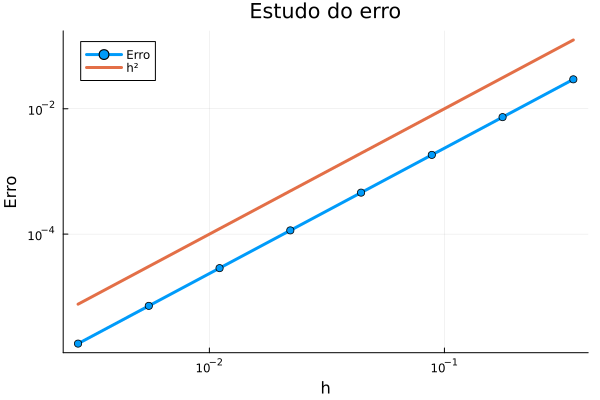

In [152]:
plot_estudo_do_erro()

  0.000208 seconds (217 allocations: 30.156 KiB)
  0.000320 seconds (513 allocations: 125.891 KiB)
  0.001026 seconds (1.68 k allocations: 596.766 KiB)
  0.005549 seconds (6.31 k allocations: 2.716 MiB)
  0.026014 seconds (24.77 k allocations: 10.355 MiB, 5.89% gc time)
  0.236400 seconds (98.50 k allocations: 45.037 MiB, 0.83% gc time)
  2.828292 seconds (393.42 k allocations: 193.068 MiB, 0.21% gc time)
 64.593813 seconds (1.57 M allocations: 811.513 MiB, 0.50% gc time)
 67.966800 seconds (2.10 M allocations: 1.078 GiB, 0.50% gc time)


"Tabela com os valores de h e erro:"

Row,h,erro
,Float64,Float64
1,0.353553,0.0294644
2,0.176777,0.00734814
3,0.0883883,0.00183603
4,0.0441942,0.000458945
5,0.0220971,0.000114733
6,0.0110485,2.86829e-5
7,0.00552427,7.17071e-6
8,0.00276214,1.79268e-6


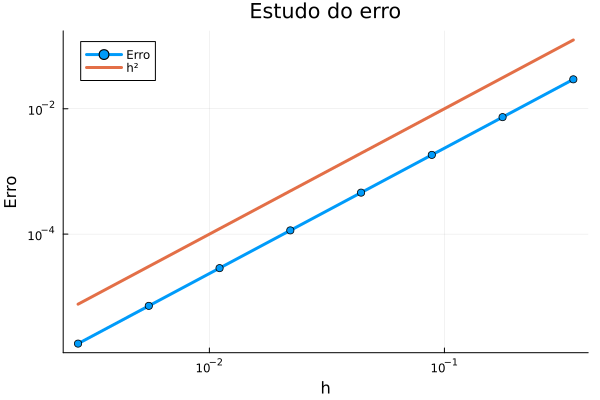

In [153]:
plot_estudo_do_erro_cuda()

In [173]:
a = CUDA.zeros(2, 3)

2×3 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In [174]:
using CUDA 

const n = 10 # 1048576, number of elements in 1D arrays
const THREADS_PER_BLOCK = 5

# create a vector [0.0, 0.0, 0.0...], and send to GPU
C = zeros(Float32, n) |> cu 

# create two vectors, fill them with 1s and 2s, and send to GPU
A = fill(1.0f0, n) |> cu 
B = fill(2.0f0, n) |> cu

function add!(c, a, b)
    # compute the thread_id
    if threadIdx().x == 1
        for i = 1:5
            @inbounds c[i] = 100
        end
    end
    
    x = (blockIdx().x - 1) * blockDim().x + threadIdx().x 

    # i'th thread should get the i'th elements of a and b 
    # sum them, and then store them in i'th element of c
    @inbounds c[x] = a[x] + b[x]
    return
end

threads = THREADS_PER_BLOCK # 256
blocks = n ÷ threads # 4096

# launch the kernel with 4096 blocks, of 256 threads each
@cuda threads=threads blocks=blocks add!(C, A, B)

CUDA.HostKernel for add!(CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1})

In [175]:
C

10-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0